<a href="https://colab.research.google.com/github/PabloParadaSouto/Automatica/blob/master/Problema_Busqueda_en_grafo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

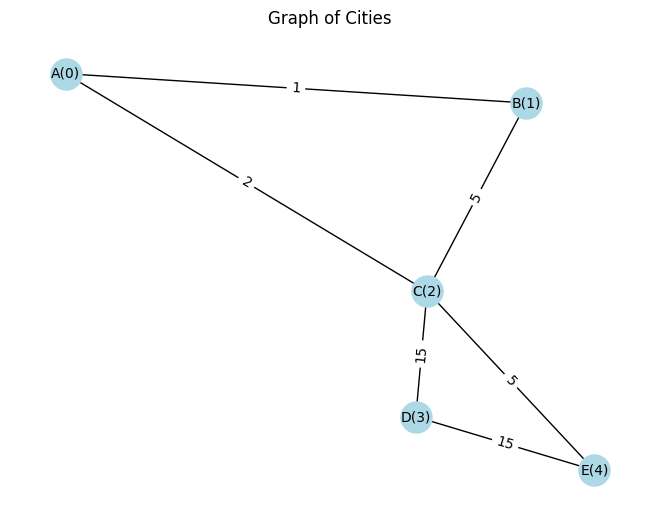

Inicializamos la valoración de los estados 5
Value interaction finalizado:  [2.08049753 2.39217526 2.65896167 0.         2.54422495]


In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

GAMMA = 0.9


class Graph:
    def __init__(self):
        self.vertices = set()
        self.edges = {}

    def add_vertex(self, vertex):
        self.vertices.add(vertex)
        self.edges[vertex] = {}

    def add_edge(self, start, end, distance):
        if start not in self.vertices:
            self.add_vertex(start)
        if end not in self.vertices:
            self.add_vertex(end)
        self.edges[start][end] = distance
        self.edges[end][start] = distance  # Consideramos las aristas como no dirigidas

    def draw(self):
        G = nx.Graph()
        for vertex in self.vertices:
            G.add_node(vertex)
        for start in self.edges:
            for end in self.edges[start]:
                G.add_edge(start, end, weight=self.edges[start][end])

        pos = nx.spring_layout(G)
        labels = {edge: self.edges[edge[0]][edge[1]] for edge in G.edges()}

        nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_size=500, node_color='lightblue', font_size=10)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.title("Graph of Cities")
        plt.show()






# Crear grafo de ciudades
cities_graph = Graph()
cities_graph.add_edge("A(0)", "B(1)", 1)
cities_graph.add_edge("A(0)", "C(2)", 2)
cities_graph.add_edge("B(1)", "C(2)", 5)
#cities_graph.add_edge("B", "D", 20)
cities_graph.add_edge("C(2)", "D(3)", 15)
cities_graph.add_edge("C(2)", "E(4)", 5)
cities_graph.add_edge("D(3)", "E(4)", 15)

# Dibujar el grafo de ciudades
cities_graph.draw()

#Creamos el modelo
# Definir las dimensiones
num_estados = 5
num_acciones=5

# Crear el diccionario principal
P = {}

# Rellenar el diccionario principal con otro diccionario para cada valor
for i in range(num_estados):
    P[i] = {}
    #print ("diccionario de ",i," vale ",P[i])
    #print ("tipo de P[i] ",type(P[i]))
    for j in range (num_acciones):
      P[i][j]=[]
      #print ("valor j ",j, "tipo ",type(P[i][j]),"valor ",P[i][j])

#probability = next_state[0]
#new_state = next_state[1]
#reward = next_state[2]

#Desde A
P[0][0]=((0.66,1,1,'False'),) #voy a b
P[0][1]=((0.33,2,-2,'False'),) # voy a c
P[0][2]=((0,0,0,'True'),) #voy a d, como no estan conectados la probabilidad de ir hasta alli es nula
P[0][3]=((0,0,0,'False'),) #voy a e, como no estan conectados la probabilidad de ir hasta alli es nula
P[0][4]=((0,0,0,'False'),) #ya estoy en a, la probabilidad de quedarse quieto es 0

#Desde B
P[1][0]=((0,0,0,'False'),) #ya estoy en b, probabilidad de ir a b es 0
P[1][1]=((0.166,2,-5,'False'),) #voy a c
P[1][2]=((0,0,0,'True'),) #voy a d, como no estan conectador la probabilidad de ir hasta alli es nula
P[1][3]=((0,0,0,'False'),) #voy a e, como no estan conectados la probabilidad de ir hasta alli es nula
P[1][4]=((0.833,0, 1,'False'),) #voy a a

#Desde C
P[2][0]=((0.8148,1,-5,'False'),) #voy a b
P[2][1]=((0,0,0,'False'),) #ya estoy en c, la probabilidad de quedarse quieto es 0
P[2][2]=((0.4444,3,-15,'True'),) #voy a d
P[2][3]=((0.8148,4,-5,'False'),) #voy a e
P[2][4]=((0.9259,0, 1,'False'),) #voy a a

#Desde D
P[3][0]=((0,0,0,'False'),) #voy a b, como no estan conectados la probabilidad de ir hasta alli es nula
P[3][1]=((0.5,2,-15,'False'),) #voy a c
P[3][2]=((0,0,0,'True'),) #ya estoy en d, la probabilidad de quedarse quieto es 0
P[3][3]=((0.5,4,-15,'False'),) #voy a e
P[3][4]=((0,0,0,'False'),) #voy a a, como no estan conectados la probabilidad de ir hasta alli es nula

#Desde E
P[4][0]=((0,0,0,'False'),) #voy a b, como no estan conectados la probabilidad de ir hasta alli es nula
P[4][1]=((0.75,2,1,'False'),) #voy a c
P[4][2]=((0.25,3,-15,'True'),) # voy a d
P[4][3]=((0,0,0,'False'),) #ya estoy en e, la probabilidad de quedarse quieto es 0
P[4][4]=((0,0,0,'False'),) #voy a a, como no estan conectados la probabilidad de ir hasta alli es nula


class Agent:
  politica_cambiada=True

  def __init__(self, P):
    print ("Inicializamos la valoración de los estados", 5)
    #solo se podrían inicializar los estados no terminales con un valor distinto de cero..
    self.value_function = np.zeros(5)
    #construimos una política determininsta, en cada estado se propone una única acción (las acciones son valores enterores entre 0 y 3)
    #la politica inicial sugiere ejecutar la acción cero para todos los estados
    self.policy = np.zeros(5, dtype=int)
    self.P=P

  def value_iteration(self):
    umbral_theta=1e-3

    self.value_function = np.zeros(5)
    copia_value_function =  np.zeros(5, dtype=float)
    nS=5
    nA=5

    while True:
      #para cada estado
      for state in range(nS):
        #se inician acciones a cero
        acciones=np.zeros(5)
        #para cada accion posible
        for action in range(nA):
          #para cada estado siguiente de esa accion
          for next_state in self.P[state][action]:

            probability = next_state[0]
            new_state = next_state[1]
            reward=next_state[2]



            #actualizo sumatorio de esa accion
            acciones[action] += probability*(reward + GAMMA*self.value_function[new_state])


        #accion que maximiza
        copia_value_function[state]=np.max(acciones)


      diff = max(np.abs(copia_value_function - self.value_function))
      #print ("delta ",diff)
      #input ("pulsa para seguir ")
      if diff <= umbral_theta:
          self.value_function = copia_value_function.copy()
          break
      else:
          self.value_function = copia_value_function.copy()
          #reiniciamos para el sumatorio de la siguiente interaccion
          copia_value_function = np.zeros(nS)
          #print(updated_value_function, '\n')
          #print(value_function)

    print("Value interaction finalizado")



agent = Agent(P)
agent.value_iteration()
